In [1]:
import datetime as dt
import os
import math as m

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import eb

In [2]:
#########################################################____INPUT____#############################################################################
# Tage mit mittlerer Außentemperatur < 15 bzw. 12°C. Wetterdatensatz TRY2017_Mietraching_extrem
Heiztage = {'15':266,'12':211}

ht = '12'
dK = 5
ex=False
eb.set_rc_eb()

C:\Users\Roman\AppData\Local\Temp/ipykernel_25564/1894238257.py:31: DtypeWarning: Columns (12,17,18,19,28,29,64,65,68,69,70,77,78,79,80,81,82,83,84,85,89,90,91,92,93,94,95,105) have mixed types.Specify dtype option on import or set low_memory=False.
  df2 = eb.load_bui(eb.files['tf'][bui]['raw']).loc['2021-09':]
C:\Users\Roman\AppData\Local\Temp/ipykernel_25564/1894238257.py:31: DtypeWarning: Columns (14,19,49,75,84,94) have mixed types.Specify dtype option on import or set low_memory=False.
  df2 = eb.load_bui(eb.files['tf'][bui]['raw']).loc['2021-09':]
C:\Users\Roman\AppData\Local\Temp/ipykernel_25564/1894238257.py:31: DtypeWarning: Columns (14,19) have mixed types.Specify dtype option on import or set low_memory=False.
  df2 = eb.load_bui(eb.files['tf'][bui]['raw']).loc['2021-09':]


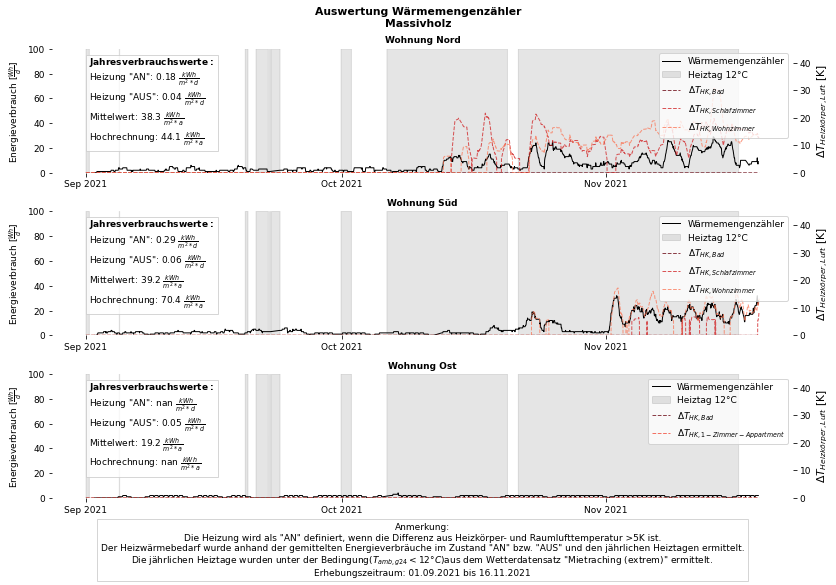

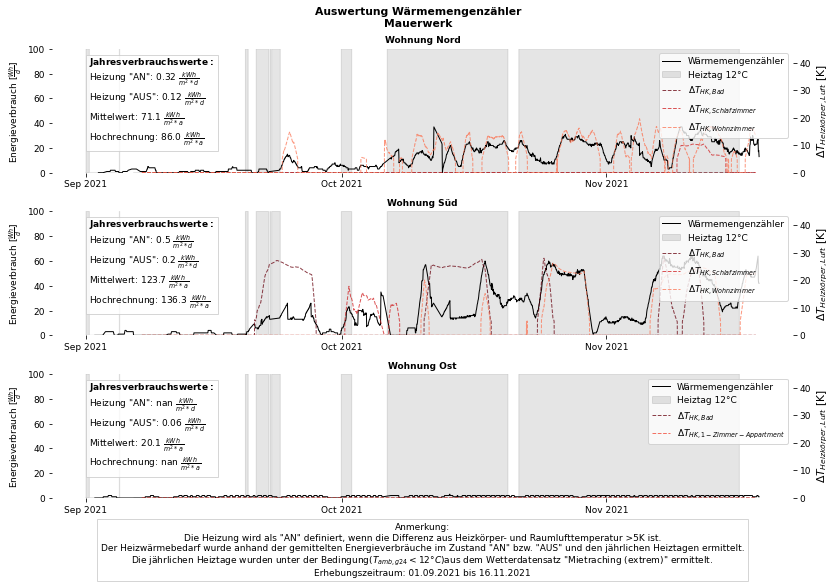

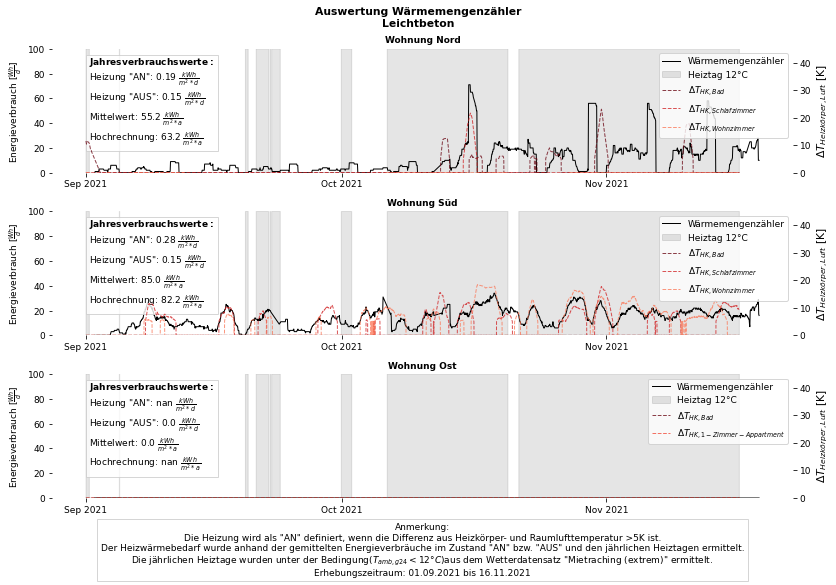

In [3]:
#########################################################____Skript____#############################################################################
heat={}
wd = eb.load_amb(eb.files['tf']['WD']['1min']).loc['2021-09':]
T_amb_g24 = wd['T_amb'].rolling('D').mean()
T_amb_g24[T_amb_g24<float(ht)] = 1
T_amb_g24[T_amb_g24>=float(ht)] = 0
#for bui in ['MH']:
for bui in eb.buid:
    if bui not in heat:
        heat[bui] = {}
    df = pd.read_csv(eb.files['em'][bui]['1min'], index_col = [0], header=[0,1,2])
    df.index = pd.to_datetime(df.index)
    df.drop('TPID',axis=1,level=2,inplace=True)
    meters = {'HQ':'Energie','VW':'Volumen','H':'Heizung','W':'Wasser'}
    idx = []
    for col in df.columns:
        t = '_'.join(col)
        try:
            app = eb.wohnungen3[t.split('_')[0]]
        except:
            app = t
        meter = t.split('_')[-2]
        unit = t.split('_')[-1]
        clmn = (app,unit,meter)
        idx.append(clmn)

    df.columns = pd.MultiIndex.from_tuples(idx)
    for col in df.filter(like='HQ').columns:
        df[col] = df[col]/1000

    df2 = eb.load_bui(eb.files['tf'][bui]['raw']).loc['2021-09':]
    fig,axs = plt.subplots(3,1,figsize=eb.din_a4_landscape)
    fig.subplots_adjust(bottom=0.1)
    axs2=[]
    fig.suptitle(f'Auswertung Wärmemengenzähler\n{eb.buid[bui]}',fontsize='large',fontweight='bold',va='top',ha='center', 
        #bbox={"facecolor":"orange", "alpha":0.5, "pad":5}
        )
    for i, app in enumerate(eb.wohnungen):
        # set axis title
        axs[i].set_title(f'Wohnung {eb.wohnungen[app]}', fontsize='medium')

        #plot Wärmemengenzähler
        dfplot = df[app].resample('H').last().dropna(how='all').fillna(method='bfill')['HQ','H'].diff().rolling('D').sum()
        axs[i].plot(dfplot, color = 'k',label='Wärmemengenzähler')

        #plot Heiztage
        axs[i].fill_between(T_amb_g24.index,T_amb_g24*100,alpha=0.1,color='k',label=f'Heiztag {ht}°C')

        #plot Heizkörpertemperaturen
        axs2.append(axs[i].twinx())
        thk = (df2[app].filter(like='pt_Thk').rolling('D').mean()).subtract((df2[app].filter(like='trh_Tair').rolling('D').mean().mean(axis=1)),axis='index')
        thk[thk < dK] = 0
        for col in thk:
            axs2[i].plot(thk[col],label = r'$\Delta T_{' +str('HK,')+ str(eb.rooms[col[0]]) + '}$', linestyle='dashed',alpha=0.75)
        
        eb.recolor_lines(ax=axs2[i],cmap=eb.c_temp)

        han1,lab1 = axs[i].get_legend_handles_labels()
        han2,lab2 = axs2[i].get_legend_handles_labels()

        axs2[i].legend(labels=lab1+lab2,handles=han1+han2,loc='upper right',frameon=True)
        axs2[i].set_ylabel(r'$\Delta T_{' + str('Heizkörper, Luft') + '}$ [K]',fontsize='large')
        axs2[i].set_ylim(0,45)

        #calculate heating demant
        df3 = df[app].dropna(how='all').fillna(method='bfill')['HQ'].diff().rolling('D').sum()
        df3['on_off'] = thk.max(axis=1).resample('1min').max()

        heatoff = round(
            (((df3[df3['on_off'] == 0.0].resample('D').last()['H'])).mean())/eb.area[app]['sum']
            ,2)

        heaton = round(
            ((df3[df3['on_off'] > 0.0].resample('D').last()['H'])).mean()/eb.area[app]['sum']
            ,2)

        q_tot = round(
            ((df3.resample('D').last()['H'])).mean()/eb.area[app]['sum']*365
            ,1)
    
        approx = round(heaton*Heiztage[ht]+(365-Heiztage[ht])*heatoff,1)
        heat[bui][app] = (q_tot,heatoff,heaton)

        #Infobox
        axs[i].text(
                0.05,
                0.95, 
                r"$\bf{"+str('Jahresverbrauchswerte:')+'}$\n' + 
                f'Heizung "AN": {heaton} '+ r'$\frac{kWh}{m^2*d}$'+ 
                f'\nHeizung "AUS": {heatoff} '+ r'$\frac{kWh}{m^2*d}$'+ 
                f'\nMittelwert: {q_tot} '+ r'$\frac{kWh}{m^2*a}$'+ 
                f'\nHochrechnung: {approx} '+ r'$\frac{kWh}{m^2*a}$',      
                fontsize = 'medium', 
                style='normal', 
                ha = 'left', 
                va = 'top',
                transform=axs[i].transAxes,
                bbox=eb.eb_bbox
                )
    
    # clean up axes
    for ax in axs:
        ax.set_ylim(0,100)
        ax.set_ylabel('Energieverbrauch ' + r'$[\frac{Wh}{d}]$')
        ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %Y'))

    stand = min(wd.index.max().round('D'),df.index.max().round('D'))-dt.timedelta(days=1)
    stand = stand.strftime('%d.%m.%Y')

    # footnote
    axs[i].annotate(
        f'Anmerkung:\nDie Heizung wird als "AN" definiert, wenn die Differenz aus Heizkörper- und Raumlufttemperatur >{dK}K ist.\n' + 
        f'Der Heizwärmebedarf wurde anhand der gemittelten Energieverbräuche im Zustand "AN" bzw. "AUS" und den jährlichen Heiztagen ermittelt.\n' +
        f'Die jährlichen Heiztage wurden unter der Bedingung' + r'$(T_{amb,g24} < '+ str(ht) + r'°C)$' + f'aus dem Wetterdatensatz "Mietraching (extrem)" ermittelt.\n' +
        f'Erhebungszeitraum: 01.09.2021 bis {stand}',
        xy = (0.5, -0.2),
        xycoords='axes fraction',
        ha='center',
        va="top",
        bbox=eb.eb_bbox
        )
    fig.tight_layout()

    if ex:
        eb.export(fig,os.path.join(eb.dir_results,'Energiebedarf'),f'{bui}_Energieverbrauch',['pdf'],show=True)

In [4]:
dfheat = pd.DataFrame.from_dict({(i,j): heat[i][j] 
                           for i in heat.keys() 
                           for j in heat[i].keys()},
                       orient='index')
dfheat.columns = ('ann_mean','off_daily','on_daily')
dfheat.index = pd.MultiIndex.from_tuples(dfheat.index.to_list())
dfheat['ann_calc'] = dfheat['on_daily']*Heiztage['15']+dfheat['off_daily']*(365-Heiztage['15'])

if ex:
    exdir = os.path.join(eb.dir_results,'Energiebedarf')
    if not os.path.isdir(exdir):
        os.makedirs(exdir)
    dfheat.to_csv(os.path.join(exdir,'auswertung_energieverbrauch.csv'))

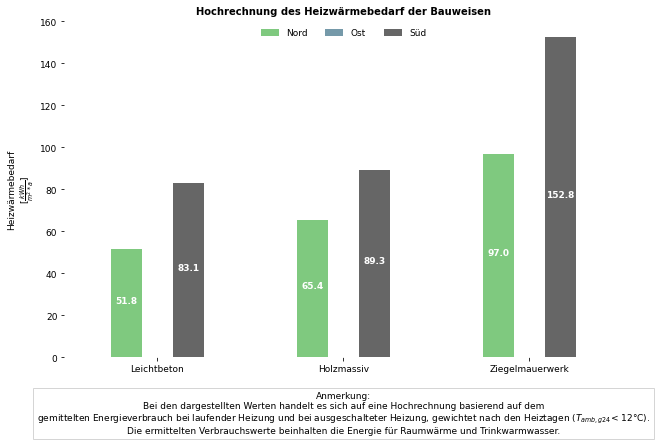

In [5]:
fig, axs = plt.subplots(figsize=eb.in_doc)
fig.subplots_adjust(bottom=0.1)
df = dfheat[['ann_calc']].unstack().T

df = df[['MH','LB','MW']]

df.T.plot.bar(ax = axs,cmap=eb.truncate_colormap('Accent'))

axs.set_title('Hochrechnung des Heizwärmebedarf der Bauweisen', fontweight = 'bold')
axs.set_ylabel('Heizwärmebedarf\n'+ r'$[\frac{kWh}{m^2*a}]$')
axs.set_xticklabels([ 'Leichtbeton','Holzmassiv', 'Ziegelmauerwerk'], rotation=0)

axs.legend(labels=['Nord','Ost','Süd'],loc='upper center',frameon=False,ncol=3)
xticks=[]
for bar in axs.patches:
    xticks.append(bar.get_x())

    axs.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        round(bar.get_height(),1),
        ha='center',
        color='w',
        weight='bold',
        )
if ex:
    eb.export(fig,exdir,'Vergleich_Heizwärmebedarf_no_footnote',extlist=['pdf','svg','png'])

# footnote
axs.annotate(f'Anmerkung:\nBei den dargestellten Werten handelt es sich auf eine Hochrechnung basierend auf dem\ngemittelten Energieverbrauch bei laufender Heizung und bei ausgeschalteter Heizung, gewichtet nach den Heiztagen ('r'$T_{amb,g24}$' +f'< {ht}°C).\nDie ermittelten Verbrauchswerte beinhalten die Energie für Raumwärme und Trinkwarmwasser.',
    xy = (0.5, -0.1),
    xycoords='axes fraction',
    ha='center',
    va="top",
    bbox=eb.eb_bbox
    )
#fig.tight_layout()
if ex:
    eb.export(fig,exdir,'Vergleich_Heizwärmebedarf',extlist=['pdf','png'])
